<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

#  K-Nearest Neighbors with `scikit-learn`

_Authors: Alex Sherman (DC)_

<a id="learning-objectives"></a>
## Learning Objectives

1. Utilize the KNN model on the iris data set.
2. Implement scikit-learn's KNN model.
3. Assess the fit of a KNN Model using scikit-learn.

### Lesson Guide
- [Learning Objectives](#learning-objectives)
- [Loading the Iris Data Set](#overview-of-the-iris-dataset)
	- [Terminology](#terminology)
- [Exercise: "Human Learning" With Iris Data](#exercise-human-learning-with-iris-data)
- [Human Learning on the Iris Data Set](#human-learning-on-the-iris-dataset)
- [K-Nearest Neighbors (KNN) Classification](#k-nearest-neighbors-knn-classification)
	- [Using the Train/Test Split Procedure (K=1)](#using-the-traintest-split-procedure-k)
- [Tuning a KNN Model](#tuning-a-knn-model)
	- [What Happens If We View the Accuracy of our Training Data?](#what-happen-if-we-view-the-accuracy-of-our-training-data)
	- [Training Error Versus Testing Error](#training-error-versus-testing-error)
- [Standardizing Features](#standardizing-features)
	- [Use `StandardScaler` to Standardize our Data](#use-standardscaler-to-standardize-our-data)
- [Comparing KNN With Other Models](#comparing-knn-with-other-models)

In this lesson, we will get an intuitive and practical feel for the **k-Nearest Neighbors** model. kNN is a **non-parametric model**. So, the model is not represented as an equation with parameters (e.g. the $\beta$ values in linear regression).

First, we will make a model by hand to classify iris flower data. Next, we will automatedly make a model using kNN.

> You may have heard of the clustering algorithm **k-Means Clustering**. These techniques have nothing in common, aside from both having a parameter k!

---

<a id="k-nearest-neighbors-knn-classification"></a>
## K-Nearest Neighbors (KNN) Classification
---

K-nearest neighbors classification is (as its name implies) a classification model that uses the "K" most similar observations in order to make a prediction.

KNN is a supervised learning method; therefore, the training data must have known target values.

The process of prediction using KNN is fairly straightforward:

1. Pick a value for K.
2. Search for the K observations in the data that are "nearest" to the measurements of the unknown iris.
    - Euclidian distance is often used as the distance metric, but other metrics are allowed.
3. Use the most popular response value from the K "nearest neighbors" as the predicted response value for the unknown iris.

The visualizations below show how a given area can change in its prediction as K changes.

- Colored points represent true values and colored areas represent a **prediction space**. (This is called a Voronoi Diagram.)
- Each prediction space is wgere the majority of the "K" nearest points are the color of the space.
- To predict the class of a new point, we guess the class corresponding to the color of the space it lies in.

<a id="knn-classification-map-for-iris-k"></a>
### KNN Classification Map for Iris (K=1)

![1NN classification map](../assets/knn_1.png)

### KNN Classification Map for Iris (K=3)

![5NN classification map](../assets/knn_3.png)

### KNN Classification Map for Iris (K=5)

![15NN classification map](../assets/knn_5.png)

<a id="knn-classification-map-for-iris-k"></a>
### KNN Classification Map for Iris (K=7)

![50NN classification map](../assets/knn_7.png)

We can see that, as K increases, the classification spaces' borders become more distinct. However, you can also see that the spaces are not perfectly pure when it comes to the known elements within them.

**How are outliers affected by K?** As K increases, outliers are "smoothed out". Look at the above three plots and notice how outliers strongly affect the prediction space when K=1. When K=50, outliers no longer affect region boundaries. This is a classic bias-variance tradeoff -- with increasing K, the bias increases but the variance decreases.

**Question:** What's the "best" value for K in this case?

**Answer:** 
The value which produces the most accurate predictions on **unseen data**. We want to create a model that generalizes!

For the rest of the lesson, we will be using a dataset containing the 2015 season statistics for ~500 NBA players. This dataset leads to a nice choice of K, as we'll see below. The columns we'll use for features (and the target 'pos') are:


| Column | Meaning |
| ---    | ---     |
| pos | C: Center. F: Front. G: Guard |
| ast | Assists per game | 
| stl | Steals per game | 
| blk | Blocks per game |
| tov | Turnovers per game | 
| pf  | Personal fouls per game | 

For information about the other columns, see [this glossary](https://www.basketball-reference.com/about/glossary.html).

In [1]:
# Read the NBA data into a DataFrame.
import pandas as pd

path = '../data/NBA_players_2015.csv'
nba = pd.read_csv(path, index_col=0)

In [2]:
nba.head()

,player,pos,age,bref_team_id,g,gs,mp,fg,fga,fg_,...,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP
season_end,,,,,,,,,,,,,,,,,,,,,
2015,Quincy Acy,F,24,NYK,52,21,19.2,2.2,4.6,0.469,...,15.1,14.7,0.6,0.5,1.0,0.050,-2.6,-0.7,-3.4,-0.3
2015,Jordan Adams,G,20,MEM,18,0,7.3,1.0,2.1,0.474,...,15.9,17.7,0.0,0.2,0.2,0.076,-2.3,1.8,-0.5,0.0
2015,Steven Adams,C,21,OKC,51,50,24.2,3.0,5.5,0.550,...,19.2,14.8,1.0,1.8,2.8,0.109,-2.0,2.0,-0.1,0.6
2015,Jeff Adrien,F,28,MIN,17,0,12.6,1.1,2.6,0.432,...,12.9,14.1,0.2,0.2,0.4,0.093,-2.6,0.8,-1.8,0.0
2015,Arron Afflalo,G,29,TOT,60,54,32.5,5.0,11.8,0.426,...,10.9,19.6,1.4,0.7,2.1,0.051,-0.2,-1.4,-1.6,0.2


In [3]:
# Map positions to numbers (C --> 0, F --> 1, G --> 2)
nba['pos_num'] = nba.pos.map({'C':0, 'F':1, 'G':2})

In [4]:
# Create feature matrix (X).
feature_cols = ['ast', 'stl', 'blk', 'tov', 'pf']
X = nba[feature_cols]

In [5]:
# Create response vector (y).
y = nba.pos_num

<a id="using-the-traintest-split-procedure-k"></a>
### Using the Train/Test Split Procedure (K=1)

In [6]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics

#### Step 1: Split X and y into training and testing sets (using `random_state` for reproducibility).

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=99)

#### Step 2: Train the model on the training set (using K=1).

In [8]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=1, p=2,
           weights='uniform')

#### Step 3: Test the model on the testing set and check the accuracy.

In [9]:
y_pred_class = knn.predict(X_test)
print((metrics.accuracy_score(y_test, y_pred_class)))

0.6166666666666667


**Question:** If we had trained on the entire dataset and tested on the entire dataset, using 1-KNN what accuracy would we likely get? If the resulting accuracy is not this number, what must some data points look like?

**Answer:** We would expect nearly 100% accuracy. The points tested on would have a distance of zero from themselves (in the training set), so the correct classes would be predicted! If we get less than 100% accuracy, then we must have some points in our data set that are the same point but a different class.

#### Repeating for K=50.

In [10]:
knn = KNeighborsClassifier(n_neighbors=50)
knn.fit(X_train, y_train)
y_pred_class = knn.predict(X_test)
print((metrics.accuracy_score(y_test, y_pred_class)))

0.675


**Question:** Suppose we again train and test on the entire data set, but using 50-KNN. Would we expect the accuracy to be higher, lower, or the same as compared to 1-KNN?

**Answer:** The accuracy will decrease. 50-KNN would start misclassifying points. We used to know the correct answers since each points is a distance of zero from itself! Now, we take the majority class of the closest 50 points, so we are bound to get many more incorrect.

#### Comparing Testing Accuracy With Null Accuracy

Null accuracy is the accuracy that can be achieved by **always predicting the most frequent class**. For example, if most players in our data set are Centers, we would always predict Center.

The null accuracy is a benchmark against which you may want to measure every classification model.

#### Examine the class distribution from the training set.

Remember that we are comparing KNN to this simpler model. So, we must find the most frequent class **of the training set**.

In [11]:
most_freq_class = y_train.value_counts().index[0]

most_freq_class

1

#### Compute null accuracy.

In [12]:
len(y_test)

120

In [13]:
y_test.value_counts()[most_freq_class] / len(y_test)

0.4083333333333333

<a id="what-happen-if-we-view-the-accuracy-of-our-training-data"></a>
### What Happens If We View the Accuracy of our Training Data?

In [14]:
# create list to store results
scores = []

# loop through 100 models
for k in range(1,100):
    # Instantiate
    knn = KNeighborsClassifier(n_neighbors=k)
    
    # Fit
    knn.fit(X,y)
    
    # Predict
    pred = knn.predict(X)
    
    # Score
    score = float(sum(pred == y)) / len(y)
    
    #Append results
    scores.append([k, score])

In [15]:
data = pd.DataFrame(scores,columns=['k','score'])

#data.head()
data.plot.line(x='k',y='score');

**Question:** As K increases, why does the accuracy fall?

**Answer:** More points are used to find each class. At some point, increasing K stops eliminating outliers and starts smoothing over the actual class boundaries, resulting in mispredictions.

#### Search for the "best" value of K.

In [16]:
# Calculate TRAINING ERROR and TESTING ERROR for K=1 through 100.

k_range = list(range(1, 101))
training_error = []
testing_error = []

# Find test accuracy for all values of K between 1 and 100 (inclusive).
for k in k_range:

    # Instantiate the model with the current K value.
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    
    # Calculate training error (error = 1 - accuracy).
    y_pred_class = knn.predict(X)
    training_accuracy = metrics.accuracy_score(y, y_pred_class)
    training_error.append(1 - training_accuracy)
    
    # Calculate testing error.
    y_pred_class = knn.predict(X_test)
    testing_accuracy = metrics.accuracy_score(y_test, y_pred_class)
    testing_error.append(1 - testing_accuracy)

In [17]:
# Allow plots to appear in the notebook.
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [18]:
# Create a DataFrame of K, training error, and testing error.
column_dict = {'K': k_range, 'training error':training_error, 'testing error':testing_error}
df = pd.DataFrame(column_dict).set_index('K').sort_index(ascending=False)
df.head()

,training error,testing error
K,,
100,0.382845,0.366667
99,0.378661,0.358333
98,0.384937,0.366667
97,0.384937,0.366667
96,0.380753,0.366667


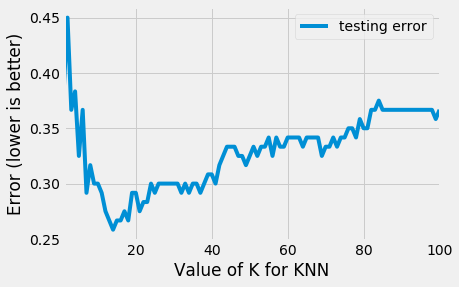

In [19]:
# Plot the relationship between K (HIGH TO LOW) and TESTING ERROR.
df.plot(y='testing error');
plt.xlabel('Value of K for KNN');
plt.ylabel('Error (lower is better)');

In [20]:
# Find the minimum testing error and the associated K value.
df.sort_values('testing error').head()

,training error,testing error
K,,
14,0.299163,0.258333
13,0.307531,0.266667
18,0.307531,0.266667
16,0.299163,0.266667
15,0.309623,0.266667


In [21]:
# Alternative method:
min(list(zip(testing_error, k_range)))

(0.2583333333333333, 14)

<a id="training-error-versus-testing-error"></a>
### Training Error Versus Testing Error

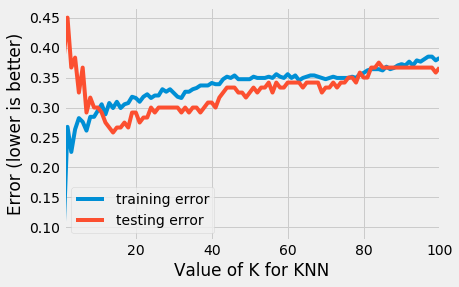

In [22]:
# Plot the relationship between K (HIGH TO LOW) and both TRAINING ERROR and TESTING ERROR.
df.plot();
plt.xlabel('Value of K for KNN');
plt.ylabel('Error (lower is better)');

- **Training error** decreases as model complexity increases (lower value of K).
- **Testing error** is minimized at the optimum model complexity.

Evaluating the training and testing error is important. For example:

- If the training error is much lower than the test error, then our model is likely overfitting. 
- If the test error starts increasing as we vary a hyperparameter, we may be overfitting.
- If either error plateaus, our model is likely underfitting (not complex enough).

#### Making Predictions on Out-of-Sample Data

Given the statistics of a (truly) unknown NBA player, how do we predict his position?

In [23]:
import numpy as np

# Instantiate the model with the best-known parameters.
knn = KNeighborsClassifier(n_neighbors=14)

# Re-train the model with X and y (not X_train and y_train). Why?
knn.fit(X, y)

# Make a prediction for an out-of-sample observation.
knn.predict(np.array([2, 1, 0, 1, 2]).reshape(1, -1))

array([2])

What could we conclude?

- When using KNN on this data set with these features, the **best value for K** is likely to be around 14.
- Given the statistics of an **unknown player**, we estimate that we would be able to correctly predict his position about 74% of the time.

<a id="standardizing-features"></a>
## Standardizing Features
---

There is one major issue that applies to many machine learning models: They are sensitive to feature scale. 

> KNN in particular is sensitive to feature scale because it (by default) uses the Euclidean distance metric. To determine closeness, Euclidean distance sums the square difference along each axis. So, if one axis has large differences and another has small differences, the former axis will contribute much more to the distance than the latter axis.

This means that it matters whether our feature are centered around zero and have similar variance to each other.

Unfortunately, most data does not naturally start at a mean of zero and a shared variance. Other models tend to struggle with scale as well, even linear regression, when you get into more advanced methods such as regularization.

Fortuantely, this is an easy fix.

<a id="use-standardscaler-to-standardize-our-data"></a>
### Use `StandardScaler` to Standardize our Data

StandardScaler standardizes our data by subtracting the mean from each feature and dividing by its standard deviation.

#### Separate feature matrix and response for scikit-learn.

In [24]:
# Create feature matrix (X).
feature_cols = ['ast', 'stl', 'blk', 'tov', 'pf']

X = nba[feature_cols]
y = nba.pos_num  # Create response vector (y).

#### Create the train/test split.

Notice that we create the train/test split first. This is because we will reveal information about our testing data if we standardize right away.

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=99)

In [26]:
X_train

,ast,stl,blk,tov,pf
season_end,,,,,
2015,2.9,1.3,0.2,1.4,2.3
2015,3.0,0.8,0.2,1.6,2.1
2015,3.3,0.8,0.8,2.0,2.3
2015,1.5,0.1,0.7,1.2,2.2
2015,0.6,0.4,0.2,0.4,1.6
2015,1.0,0.6,1.0,1.2,1.9
2015,2.4,1.0,0.3,1.4,2.0
2015,3.8,0.5,0.0,2.1,1.1
2015,0.4,0.6,0.6,1.2,1.4


#### Instantiate and fit `StandardScaler`.

In [27]:
from sklearn.preprocessing import StandardScaler

# Instantiate
scaler = StandardScaler()

# Fit and transform!!!!
X_train = scaler.fit_transform(X_train)

# Transform
X_test = scaler.transform(X_test)

In [28]:
X_train

array([[ 0.62992276,  1.49261461, -0.45609001,  0.33254583,  0.77683911],
       [ 0.68607623,  0.35277666, -0.45609001,  0.59107222,  0.50052674],
       [ 0.85453665,  0.35277666,  0.80801494,  1.10812502,  0.77683911],
       ...,
       [-0.83006754, -0.5590937 , -0.45609001, -1.08934936,  0.08605818],
       [-0.32468628, -0.33112611, -0.03472169, -0.18450697, -0.052098  ],
       [ 0.57376928,  0.35277666,  2.91485653,  0.84959862,  0.63868292]])

In [29]:
X_test

array([[-0.15622586,  0.58074425,  0.38664663, -0.05524377,  1.8820886 ],
       [ 0.06838803, -0.10315852, -0.66677417, -0.70155976, -1.0191913 ],
       [-0.60545365, -0.33112611, -0.24540585,  0.84959862,  1.05315148],
       [-0.77391406, -1.01502887, -0.45609001, -0.70155976,  0.50052674],
       [-0.60545365, -0.10315852, -0.66677417, -0.83082296, -1.29550367],
       [-0.77391406, -1.24299646, -0.24540585, -0.96008616, -1.57181604],
       [-0.10007239,  0.12480907, -0.03472169,  0.46180902,  1.74393241],
       [-0.26853281,  0.12480907,  0.38664663,  0.20328263,  0.63868292],
       [ 0.34915539,  1.03667943, -0.87745833, -0.18450697, -0.74287893],
       [-0.54930017, -0.5590937 , -0.24540585, -0.70155976, -0.32841037],
       [-0.54930017, -0.78706129, -0.87745833, -0.31377017, -0.88103512],
       [ 1.02299707,  1.03667943,  2.28280405,  1.75444101,  1.46762004],
       [-0.99852796, -0.78706129, -0.24540585, -1.47713895, -1.29550367],
       [-0.83006754, -0.33112611, -0.0

#### Fit a KNN model and look at the testing error.
Can you find a number of neighbors that improves our results from before?

In [30]:
# Calculate TRAINING ERROR and TESTING ERROR for K=1 through 100.

k_range = list(range(1, 101))
training_error = []
testing_error = []

# Find test accuracy for all values of K between 1 and 100 (inclusive).
for k in k_range:

    # Instantiate the model with the current K value.
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    
    # Calculate training error (error = 1 - accuracy).
    y_pred_class = knn.predict(X)
    training_accuracy = metrics.accuracy_score(y, y_pred_class)
    training_error.append(1 - training_accuracy)
    
    # Calculate testing error.
    y_pred_class = knn.predict(X_test)
    testing_accuracy = metrics.accuracy_score(y_test, y_pred_class)
    testing_error.append(1 - testing_accuracy)

In [31]:
# Create a DataFrame of K, training error, and testing error.
column_dict = {'K': k_range, 'training error':training_error, 'testing error':testing_error}
df = pd.DataFrame(column_dict).set_index('K').sort_index(ascending=False)
df.head()

,training error,testing error
K,,
100,0.445607,0.358333
99,0.447699,0.358333
98,0.447699,0.366667
97,0.447699,0.358333
96,0.447699,0.350000


In [32]:
# Find the minimum testing error and the associated K value.
df.sort_values('testing error').head()

,training error,testing error
K,,
8,0.391213,0.250000
28,0.410042,0.250000
15,0.391213,0.258333
40,0.416318,0.258333
37,0.405858,0.258333


In [33]:
# Calculate testing error.
knn = KNeighborsClassifier(n_neighbors=8)
knn.fit(X_train, y_train)

y_pred_class = knn.predict(X_test)
testing_accuracy = metrics.accuracy_score(y_test, y_pred_class)
testing_error = 1 - testing_accuracy

print(testing_error)

0.25


This is a small gain from 25.8 on test data previously, but it goes to prove that feature engineering can do more for an algorithm than a more advanced algo!

<a id="comparing-knn-with-other-models"></a>
## Comparing KNN With Other Models
---

**Advantages of KNN:**

- It's simple to understand and explain.
- Model training is fast.
- It can be used for classification and regression (for regression, take the average value of the K nearest points!).
- Being a non-parametric method, it is often successful in classification situations where the decision boundary is very irregular.

**Disadvantages of KNN:**

- It must store all of the training data.
- Its prediction phase can be slow when n is large.
- It is sensitive to irrelevant features.
- It is sensitive to the scale of the data.
- Accuracy is (generally) not competitive with the best supervised learning methods.